In [1]:
import os
import sqlite3

import matplotlib.pyplot as plt
import nfts.dataset
import numpy as np
import pandas as pd

In [2]:
nfts.dataset.explain()


The Moonstream NFTs dataset

To load the NFTs dataset from a SQLite file, run:
>>> ds = nfts.dataset.FromSQLite(<path to sqlite database>)

This dataset consists of the following dataframes:

Dataframe: nfts
Load using:
>>> nfts_df = ds.load_dataframe(<sqlite connection or path to sqlite db>, "nfts")

Describes the NFT contracts represented in this dataset, with a name and symbol if they were available at time of crawl.

Columns:
1. address: The Ethereum address of the NFT contract.
2. name: The name of the collection of NFTs that the contract represents.
3. symbol: The symbol of the collection of NFTs that the contract represents.

- - -

Dataframe: mints
Load using:
>>> mints_df = ds.load_dataframe(<sqlite connection or path to sqlite db>, "mints")

All token mint events crawled in this dataset.

Columns:
1. event_id: A unique event ID associated with the event.
2. transaction_hash: The hash of the transaction which triggered the event.
3. block_number: The transaction block in whic

In [3]:
DATABASE = os.path.expanduser("~/data/nfts/nfts.sqlite")
print(f"Path to SQLite database containing the NFTs dataset: {DATABASE}")

Path to SQLite database containing the NFTs dataset: /home/neeraj/data/nfts/nfts.sqlite


In [4]:
ds = nfts.dataset.FromSQLite(DATABASE)

### Who owns NFTs?

In [5]:
current_owners_df = ds.load_dataframe("current_owners")

In [6]:
current_owners_df.head()

,nft_address,token_id,owner
0,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0,0xb776cAb26B9e6Be821842DC0cc0e8217489a4581
1,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,1,0x8A73024B39A4477a5Dc43fD6360e446851AD1D28
2,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,10,0x5e5C817E9264B46cBBB980198684Ad9d14f3e0B4
3,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,11,0x8376f63c13b99D3eedfA51ddd77Ff375279B3Ba0
4,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,12,0xb5e34552F32BA9226C987769BF6555a538510BA8


In [7]:
top_owners_df = current_owners_df.groupby(["owner"], as_index=False).size().rename(columns={"size": "num_tokens"})

In [8]:
top_owners_df.sort_values("num_tokens", inplace=True, ascending=False)

#### Top 20 NFT owners

In [9]:
top_owners_df.head(10)

,owner,num_tokens
7272,0x02E4103b8A3c55AcDDF298311a9928f9Fe27822C,100045
0,0x0000000000000000000000000000000000000000,83548
470227,0xE052113bd7D7700d623414a0a4585BCaE754E9d5,51028
562045,0xcDA72070E455bb31C7690a170224Ce43623d0B6f,50131
369228,0x96bEE49d3386d674bF4E956D9B3ce61b9540409D,36751
439086,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,32905
427270,0xBa0d01220a7CeA942596123102535F800f558763,32691
7,0x000000000000000000000000000000000000dEaD,19758
277,0x0008d343091EF8BD3EFA730F6aAE5A26a285C7a2,12137
454705,0xD387A6E4e84a6C86bd90C158C6028A58CC8Ac459,11497


#### NFT ownership histogram

The following is the cumulative distribution of the number of addressses owning $n$ NFTs for each $n \geq 1$.

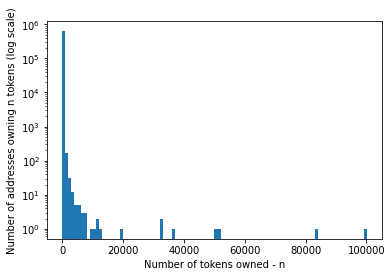

In [10]:
plt.xlabel("Number of tokens owned - n")
plt.ylabel("Number of addresses owning n tokens (log scale)")
_ = plt.hist(top_owners_df["num_tokens"], bins=100, log=True)
plt.savefig("img/tokens_owned_histogram_log.png", transparent=True)

The *overwhelming* number of NFT owners each only own a small number of tokens. There are very few addresses that own hundreds or even thousands of tokens.

**Note:** This histogram has been charted on a logarithmic scale. We have done this because the true distribution of the count of number of NFTs owned by each address follows an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution). It would be difficult to visually tell apart the differences on ownership patterns over all owners if we charted this distribution using a linear scale.

Any address which owns thousands of tokens is either purchasing those tokens automatically (if they exist on multiple contracts) or is financing the collections in which they own tokens. First, let us analye the ownership trends amount addresses which do not own large numbers of tokens. This will help us estimate trends in NFT ownership among non-algorithmic and non-smart contract owners.

For this, we set a `scale_cutoff` and only consider addresses which own a number of tokens not exceeding that cutoff.

This allows us to estimate on a linear scale, rather than a logarithmic one, how NFT ownership is distributed among human owners.

In [11]:
scale_cutoff = 1500

In [12]:
low_scale_owners = [num_tokens for num_tokens in top_owners_df["num_tokens"] if num_tokens <= scale_cutoff]

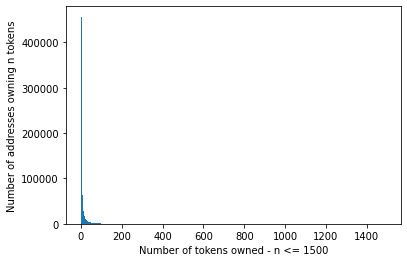

In [13]:
plt.xlabel(f"Number of tokens owned - n <= {scale_cutoff}")
plt.ylabel("Number of addresses owning n tokens")
_ = plt.hist(low_scale_owners, bins=int(scale_cutoff/5))
plt.savefig("img/tokens_owned_histogram_low_scale.png", transparent=True)

Even at this scale, it is more instructive to view the distribution on a logarithmic scale:

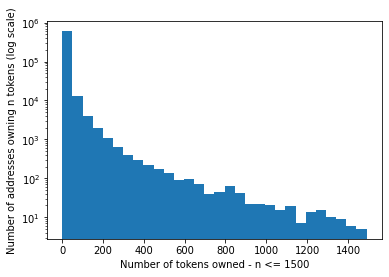

In [14]:
plt.xlabel(f"Number of tokens owned - n <= {scale_cutoff}")
plt.ylabel("Number of addresses owning n tokens (log scale)")
_ = plt.hist(low_scale_owners, bins=int(scale_cutoff/50), log=True)
plt.savefig("img/tokens_owned_histogram_log_low_scale.png", transparent=True)

This analysis shows that the *decentralized* NFT market is indeed decentralized, with proportionally few NFTs being held by addresses which are minting and purchasing NFTs at industrial scale.

**There are vanishingly few large scale NFT owners on the Ethereum blockchain.**

Note that this is an analysis of addresses, not real-world entities. It is possible for a single person or organization to use a distinct Ethereum address to control each NFT they own. This would currently be difficult enough operationally that only a handful of players in the NFT market are probably doing it. Even this would yield to a further network analysis of where the *funds* for each NFT purchase were coming from.

### The shapes of NFT collections

NFTs are released in collections, with a single contract accounting for multiple tokens.

Are there differences between ownership distributions of NFTs like the [Ethereum Name Service (ENS)](https://ens.domains/), which have utility beyond their artistic value, and those that do not currently have such use cases?

One way we can answer this question is to see how much information each NFT collection gives us about individual owners of tokens in that collection. We will do this by treating each collection as a probability distribution over owners of tokens from that collection. If the collection $C$ consists of $n$ tokens and an address $A$ owns $m$ of those tokens, we will assign that address a probability of $p_A = m/n$ in the collection's associated probability distribution. Then we will calculate the entropy:

$$H(C) = - \sum_{A} p_A \log(p_A).$$

Here, the sum is over all addresses $A$ that own at least one token from $C$.

$H(C)$ simultaneously contains information about:
1. How many tokens were issued as part of the collection $C$.
2. How evenly the tokens in $C$ are distributed over the addresses $A$ which own those tokens.

In [15]:
contract_owners_df = current_owners_df.groupby(["nft_address", "owner"], as_index=False).size().rename(columns={"size": "num_tokens"})

In [16]:
contract_owners_df.head()

,nft_address,owner,num_tokens
0,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0x429a635eD4DaF9529C07d5406D466B349EC34361,3
1,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0x5e5C817E9264B46cBBB980198684Ad9d14f3e0B4,5
2,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0x8376f63c13b99D3eedfA51ddd77Ff375279B3Ba0,1
3,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0x83D7Da9E572C5ad14caAe36771022C43AF084dbF,5
4,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0x8A73024B39A4477a5Dc43fD6360e446851AD1D28,5


In [17]:
contract_owners_groups = contract_owners_df.groupby(["nft_address"])

entropies = {}

for contract_address, owners_group in contract_owners_groups:
    total_supply = owners_group["num_tokens"].sum()
    owners_group["p"] = owners_group["num_tokens"]/total_supply
    owners_group["log(p)"] = np.log2(owners_group["p"])
    owners_group["-plog(p)"] = (-1) * owners_group["p"] * owners_group["log(p)"]
    entropy = owners_group["-plog(p)"].sum()
    entropies[contract_address] = entropy

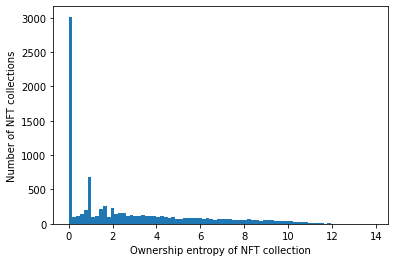

In [18]:
plt.xlabel(f"Ownership entropy of NFT collection")
plt.ylabel("Number of NFT collections")
_ = plt.hist(entropies.values(), bins=80)
plt.savefig("img/ownership_entropy.png", transparent=True)

#### Collections at the extremes

It is interesting to get a sense of what the collections look like at either extreme of this entropy spectrum.

In [19]:
sorted_entropies = [it for it in entropies.items()]
sorted_entropies.sort(key=lambda it: it[1], reverse=True)
entropies_df = pd.DataFrame.from_records(sorted_entropies, columns=["nft_address", "entropy"])

##### Highest entropy

In [20]:
entropies_df.head()

,nft_address,entropy
0,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,13.864019
1,0x60F80121C31A0d46B5279700f9DF786054aa5eE5,13.831032
2,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,13.742724
3,0xabc207502EA88D9BCa29B95Cd2EeE5F0d7936418,13.714889
4,0x5537d90A4A2DC9d9b37BAb49B490cF67D4C54E91,13.285761


[`0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85`](https://etherscan.io/address/0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85) is the [Ethereum Name Service](https://ens.domains/).

[`0x60F80121C31A0d46B5279700f9DF786054aa5eE5`](https://etherscan.io/address/0x60F80121C31A0d46B5279700f9DF786054aa5eE5) is [Rarible's](https://rarible.com/) governance token ([details](https://www.notion.so/rarible/Rarible-com-FAQ-a47b276aa1994f7c8e3bc96d700717c5)). Their aidrops are the cause of this high entropy.

[`0xC36442b4a4522E871399CD717aBDD847Ab11FE88`](https://etherscan.io/address/0xC36442b4a4522E871399CD717aBDD847Ab11FE88) is [Uniswap's](https://uniswap.org/) position NFT, representing [non-fungible liquidity positions](https://uniswap.org/blog/uniswap-v3/) on Uniswap v3.

[`0xabc207502EA88D9BCa29B95Cd2EeE5F0d7936418`](https://etherscan.io/address/0xabc207502EA88D9BCa29B95Cd2EeE5F0d7936418) are badges for [Yield Guild Games](https://yieldguild.io/), which seem to have been airdropped to many existing NFT holders.

[`0x5537d90A4A2DC9d9b37BAb49B490cF67D4C54E91`](https://etherscan.io/address/0x5537d90A4A2DC9d9b37BAb49B490cF67D4C54E91) is the [OneDayPunk](https://punkscape.xyz/) collection, which has gained popularity as a down-market Crypto Punks alternative.



##### Zero entropy

In [21]:
entropies_df.tail()

,nft_address,entropy
9287,0xfe00276E0A87E5e54ADD7C5FC6cdD80B363DEe04,0.0
9288,0xfe6b0dAccBAE832b0283CfBFEBe9543B6b7B10a8,0.0
9289,0xff881E3008f081707bdDA1644e6c92DB9599C1C0,0.0
9290,0xffC6c59F34Cd9f8861012FDDd0c7F1323082Ab86,0.0
9291,0xffCb352Fb3FdbEAab3F662378db28B8D151f210c,0.0


[`0xfe00276E0A87E5e54ADD7C5FC6cdD80B363DEe04`](https://etherscan.io/address/0xfe00276E0A87E5e54ADD7C5FC6cdD80B363DEe04).

[`0xfe6b0dAccBAE832b0283CfBFEBe9543B6b7B10a8`](https://etherscan.io/address/0xfe6b0dAccBAE832b0283CfBFEBe9543B6b7B10a8).

[`0xff881E3008f081707bdDA1644e6c92DB9599C1C0`](https://etherscan.io/address/0xff881E3008f081707bdDA1644e6c92DB9599C1C0).

[`0xffC6c59F34Cd9f8861012FDDd0c7F1323082Ab86`](https://etherscan.io/address/0xffC6c59F34Cd9f8861012FDDd0c7F1323082Ab86).

[`0xffCb352Fb3FdbEAab3F662378db28B8D151f210c`](https://etherscan.io/address/0xffCb352Fb3FdbEAab3F662378db28B8D151f210c).

All these projects are NFTs that did see release in the time period for which we collected data, but saw no further activity. That means that these are either failed projects or projects that have not yet done an official launch.

##### Low entropy

In [22]:
entropies_df.loc[entropies_df["entropy"] > 2].tail()

,nft_address,entropy
4025,0x08CdCF9ba0a4b5667F5A59B78B60FbEFb145e64c,2.004886
4026,0xA4fF6019f9DBbb4bCC61Fa8Bd5C39F36ee4eB164,2.003856
4027,0xB66c7Ca15Af1f357C57294BAf730ABc77FF94940,2.003756
4028,0x5f98B87fb68f7Bb6F3a60BD6f0917723365444C1,2.002227
4029,0x374DBF0dF7aBc89C2bA776F003E725177Cb35750,2.001823


[`0x08CdCF9ba0a4b5667F5A59B78B60FbEFb145e64c`](https://etherscan.io/address/0x08CdCF9ba0a4b5667F5A59B78B60FbEFb145e64c) is called [WorldCupToken](https://coinclarity.com/dapp/worldcuptoken/) and was last active 4 years ago. Their recent increase in activity could be in anticipation of the next soccer world cup in 2022.

[`0xA4fF6019f9DBbb4bCC61Fa8Bd5C39F36ee4eB164`](https://etherscan.io/address/0xA4fF6019f9DBbb4bCC61Fa8Bd5C39F36ee4eB164) is associated with a project called [instigators](https://instigators.network/).

[`0xB66c7Ca15Af1f357C57294BAf730ABc77FF94940`](https://etherscan.io/address/0xB66c7Ca15Af1f357C57294BAf730ABc77FF94940) is a token associated with something called the [Gems of Awareness Benefit](https://nftcalendar.io/event/gems-of-awareness-benefit-for-entheon-art-by-alex-grey-x-allyson-grey/).

[`0x5f98B87fb68f7Bb6F3a60BD6f0917723365444C1`](https://etherscan.io/address/0x5f98B87fb68f7Bb6F3a60BD6f0917723365444C1) is [SHADYCON, an NFT associated with Eminem which seems to have been marketed on Nifty Gateway](https://www.eminem.com/news/shadycon-x-nifty-gateway).

[`0x374DBF0dF7aBc89C2bA776F003E725177Cb35750`](https://etherscan.io/address/0x374DBF0dF7aBc89C2bA776F003E725177Cb35750) is [WyldFrogz](https://twitter.com/WyldFrogz), a cryptopunks derivative that seems to have some kind of planet-saving theme.

##### Medium entropy

In [23]:
entropies_df.loc[entropies_df["entropy"] > 6].tail()

,nft_address,entropy
1564,0x0ae3c3A1504E41a6877De1B854C000EC64894bEa,6.021144
1565,0x1ECA43C93D8e06FB91489818B4967014D748Da53,6.017002
1566,0xc57605Bef27ef91DbECc839e71E49574b98857Fc,6.011324
1567,0xd3f69F10532457D35188895fEaA4C20B730EDe88,6.010405
1568,0xba61aEF92ebF174DbB39C97Dd29D0F2bd3D83d33,6.009679


[`0x0ae3c3A1504E41a6877De1B854C000EC64894bEa`](https://etherscan.io/address/0x0ae3c3A1504E41a6877De1B854C000EC64894bEa) is the [Circleorzo NFT](https://opensea.io/collection/circleorzo), a collection of images of procedurally generated circles.

[`0x1ECA43C93D8e06FB91489818B4967014D748Da53`](https://etherscan.io/address/0x1ECA43C93D8e06FB91489818B4967014D748Da53) is [Cowboy Punks](https://twitter.com/cowboypunks?lang=en), which appeals to blockheads that prefer westerns to cyberpunk.

[`0xc57605Bef27ef91DbECc839e71E49574b98857Fc`](https://etherscan.io/address/0xc57605Bef27ef91DbECc839e71E49574b98857Fc) seems to be associated with the [Enigma Project](https://www.producthunt.com/posts/enigma-project) and control access to puzzle games.

[`0xd3f69F10532457D35188895fEaA4C20B730EDe88`](https://etherscan.io/address/0xd3f69F10532457D35188895fEaA4C20B730EDe88) is something called hte [RTFKT Capsule Space Drip](https://rtfkt.com/spacedrip) which I do not understand and feel too old to have a hope of ever understanding. The important thing is that it seems these NFTs can be redeemed for a physical object called a space drip. [Here's a blog post about it](https://www.one37pm.com/nft/gaming/space-drip-rtfkt-loopify).

[`0xba61aEF92ebF174DbB39C97Dd29D0F2bd3D83d33`](https://etherscan.io/address/0xba61aEF92ebF174DbB39C97Dd29D0F2bd3D83d33) is an NFT project called [Dommies](https://twitter.com/DommiesNFT).

##### Entropy as a measure of quality

Based on this analysis, the ownership entropy of an NFT collection shows promise as a measure of its quality. There are certainly examples of high entropy NFT collections (like Rarible's governance token) which have that kind of entropy simply because they have been airdropped at scale. It remains to be seen what the value of these mass airdropped tokens will be in the long term.

At the very least, the entropy measurement indicates that there is a lot of money behind those releases. This is in contrast to lower entropy releases promising thousands of tokens and only minting tens of them.